In [1]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

In [3]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

In [4]:
weather_forecast_data_1 = weather_forecast_data_1[weather_forecast_data_1['location'] != 'location']
weather_forecast_data_1['ts'] =  pd.to_datetime(weather_forecast_data_1['ts'], unit='s')
weather_forecast_data_1['base_ts'] = pd.to_datetime(weather_forecast_data_1['base_ts'], unit='s')

/tmp/ipykernel_1178882/796732019.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_1['ts'] =  pd.to_datetime(weather_forecast_data_1['ts'], unit='s')
/tmp/ipykernel_1178882/796732019.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_1['base_ts'] = pd.to_datetime(weather_forecast_data_1['base_ts'], unit='s')


In [5]:
# 평균을 구할 열 리스트
columns_to_average = [
    'temp', 'real_feel_temp', 'wet_bulb_temp', 'dew_point', 
    'wind_dir', 'wind_spd', 'wind_gust_spd', 'rel_hum', 'vis', 
    'ceiling', 'uv_idx', 'precip_prob', 'rain_prob', 'snow_prob', 
    'ice_prob', 'total_liq', 'rain', 'snow', 'ice', 'cld_cvr'
]

# 숫자형으로 변환할 수 있는 값만 변환
weather_forecast_data_1[columns_to_average] = weather_forecast_data_1[columns_to_average].apply(pd.to_numeric, errors='coerce')

In [6]:
# 'ts'로 그룹화하여 각 열의 평균 계산
average_df = weather_forecast_data_1.groupby('ts', as_index=False)[columns_to_average].mean()

weather_df = average_df

ahead_df = jeju_power_market_day_ahead

ahead_df['ts'] = pd.to_datetime(ahead_df['ts'], unit='s')

In [7]:
df = pd.merge(weather_df, ahead_df, on='ts')

In [8]:
df['hour'] = df['ts'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month'] = df['ts'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_of_week'] = df['ts'].dt.dayofweek
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ts               5641 non-null   datetime64[ns]
 1   temp             5641 non-null   float64       
 2   real_feel_temp   5641 non-null   float64       
 3   wet_bulb_temp    5641 non-null   float64       
 4   dew_point        5641 non-null   float64       
 5   wind_dir         5641 non-null   float64       
 6   wind_spd         5641 non-null   float64       
 7   wind_gust_spd    5641 non-null   float64       
 8   rel_hum          5641 non-null   float64       
 9   vis              5641 non-null   float64       
 10  ceiling          5641 non-null   float64       
 11  uv_idx           5641 non-null   float64       
 12  precip_prob      5641 non-null   float64       
 13  rain_prob        5641 non-null   float64       
 14  snow_prob        5641 non-null   float64

In [10]:
df.rename(columns={
    '하루전가격(원/kWh)': 'previous_price_kwh'
}, inplace=True)

In [11]:
df['hour_price_std'] = df.groupby('hour')['previous_price_kwh'].transform('std')

In [12]:
df = df.drop(['ts', 'month', 'hour'], axis=1)

df.rename(columns={
    '하루전가격(원/kWh)': 'previous_price_kwh'
}, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp                5641 non-null   float64
 1   real_feel_temp      5641 non-null   float64
 2   wet_bulb_temp       5641 non-null   float64
 3   dew_point           5641 non-null   float64
 4   wind_dir            5641 non-null   float64
 5   wind_spd            5641 non-null   float64
 6   wind_gust_spd       5641 non-null   float64
 7   rel_hum             5641 non-null   float64
 8   vis                 5641 non-null   float64
 9   ceiling             5641 non-null   float64
 10  uv_idx              5641 non-null   float64
 11  precip_prob         5641 non-null   float64
 12  rain_prob           5641 non-null   float64
 13  snow_prob           5641 non-null   float64
 14  ice_prob            5641 non-null   float64
 15  total_liq           5641 non-null   float64
 16  rain  

In [14]:
# df['previous_day_price'] = df['previous_price_kwh'].shift(24)
# df['previous_2day_price'] = df['previous_price_kwh'].shift(48)
# df['previous_3day_price'] = df['previous_price_kwh'].shift(72)

In [15]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

data = df

# 80%까지는 훈련 데이터로, 20%는 테스트 데이터로 사용
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

X_train, y_train = train.drop(['previous_price_kwh'], axis=1), train['previous_price_kwh']
X_test, y_test = test.drop(['previous_price_kwh'], axis=1), test['previous_price_kwh']

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# 모델 학습
model = LGBMRegressor(
    subsample=1.0,
    num_leaves=50,  # 늘리기
    n_estimators=500,
    min_child_samples=20,  # 줄이기
    max_depth=3,  # 제한적 깊이 설정
    learning_rate=0.1,
    device_type='gpu'
)
model.fit(X_train_scaled, y_train)

# 예측
y_pred = model.predict(X_test_scaled)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3674
[LightGBM] [Info] Number of data points in the train set: 5076, number of used features: 24
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3569
[LightGBM] [Info] Number of data points in the train set: 3384, number of used features: 24
[CV] END learning_rate=0.05, max_depth=-1, min_child_samples=50, n_estimators=1000, num_leaves=31, subsample=1.0; total time=   7.3s
[LightGBM] [Info] Using GPU Device: Quadro RTX 5000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 24 dense feature groups (0.12 MB) transferred to GPU in 0.005703 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 129.374947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

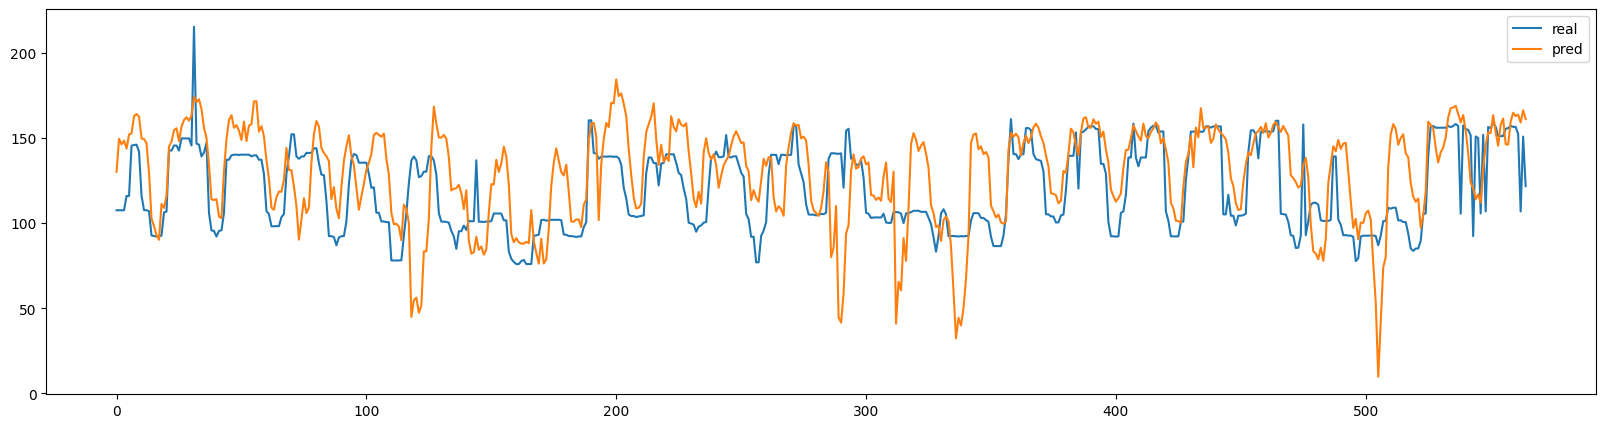

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.to_numpy(), label='real')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

In [19]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [20]:
SMAPE(y_test, y_pred)

8.709911284344546

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0]
}

# RandomizedSearchCV를 사용해 랜덤 탐색 수행
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=43, verbose=2)

random_search.fit(X_train_scaled, y_train)

# 최적의 파라미터와 성능
best_params = random_search.best_params_
best_score = -random_search.best_score_

print("Best Parameters:", best_params)
print("Best MAE Score:", best_score)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/jinjinjara1022/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
149 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
147 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jinjinjara1022/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jinjinjara1022/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1189, in fit
    super().fit(
  File "/home/jinjinjara1022/.local/lib/python3.10/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
  File "/home/jinjinjara10

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3674
[LightGBM] [Info] Number of data points in the train set: 5076, number of used features: 24
[LightGBM] [Info] Using GPU Device: Quadro RTX 5000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 24 dense feature groups (0.12 MB) transferred to GPU in 0.005691 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 129.374947
Best Parameters: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 500, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.1}
Best MAE Score: nan
